In [58]:
from pathlib import Path

import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision.transforms import Normalize
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

In [60]:
transformer = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
test_dataset = torchvision.datasets.FashionMNIST(root='./datasets', train=False,  download=True, transform=transformer)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, pin_memory=True)

In [62]:
classes = ['shirt', 'trouser', 'pullover', 'dress','coat', 'sandal', 'shirt', 'sneaker', 'bag', 'boot']

In [64]:
%run models.ipynb

In [66]:
%run utils.ipynb

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Normal Training LeNet

In [71]:
model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lenet_fmnist.pth"
model_save_path = model_path / model_name
model = LeNet().to(device)
model.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

In [73]:
# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for Lenet Normal is: {(100 * test_acc):.2f}%")

Test accuracy for Lenet Normal is: 88.91%


In [25]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

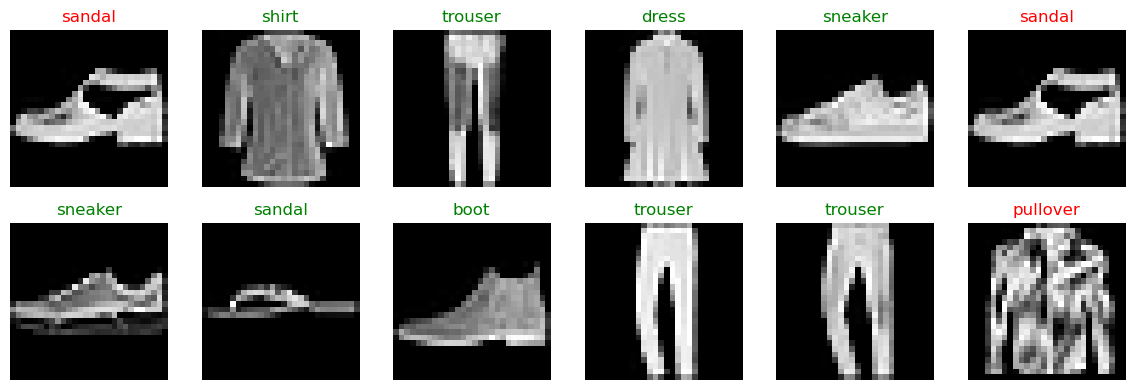

In [254]:
# torch.manual_seed(42)  # setting random seed
%matplotlib inline
figure = plt.figure(figsize=(12, 4))
indexes=[]
rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    image, label = x_batch[random_idx], y_batch[random_idx]
    indexes.append(random_idx)
    inputs = image.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model(inputs))
    figure.add_subplot(rows, cols, i)
    image = image.permute(1, 2, 0)    # CWH --> WHC
    
    plt.imshow(image.cpu().numpy(), cmap='gray')
    if label_pred == label:
        plt.title(classes[label_pred], color='g') # for correct prediction
    else:
        plt.title(classes[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();
plt.show()

In [256]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [258]:
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()


In [260]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

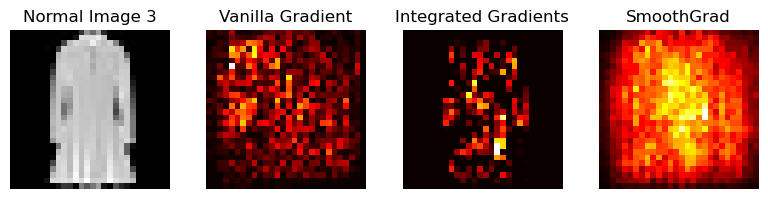

In [262]:
index = indexes[3]
image_explanation_lenet(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'lenet_normal')

# Adversarial Training LeNet

In [75]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lenet_fmnist_adv.pth"
model_save_path = model_path / model_name
model_adv = LeNet().to(device)
model_adv.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [267]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [269]:
# Applying explanation methods on the model outputs
a_batch_integrad_adv = IntegratedGradients(model_adv).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_adv[a_batch_integrad_adv<0] = 0
a_batch_saliency_adv = Saliency(model_adv).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_adv)
a_batch_smoothgrad_adv = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()


In [271]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

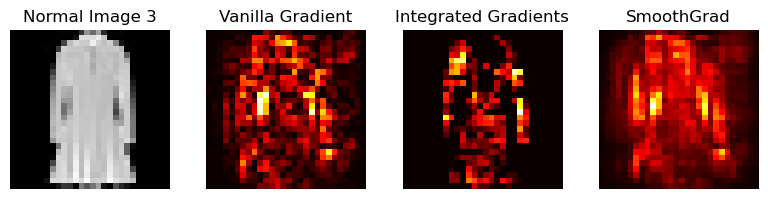

In [272]:
image_explanation_lenet(index, x_batch, y_batch, a_batch_saliency_adv, a_batch_integrad_adv, a_batch_smoothgrad_adv, 'lenet_adversarial')

# Pruning L1 Unstructured LeNet

In [276]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lenet_fmnist_l1_unstructured.pth"
model_save_path = model_path / model_name
model_l1_unstructured = LeNet().to(device)

for name, module in model_l1_unstructured.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)
        
model_l1_unstructured.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [278]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [280]:
# Applying explanation methods on the model outputs
a_batch_integrad_l1 = IntegratedGradients(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_l1[a_batch_integrad_l1<0] = 0
a_batch_saliency_l1 = Saliency(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_l1_unstructured)
a_batch_smoothgrad_l1 = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()


In [282]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

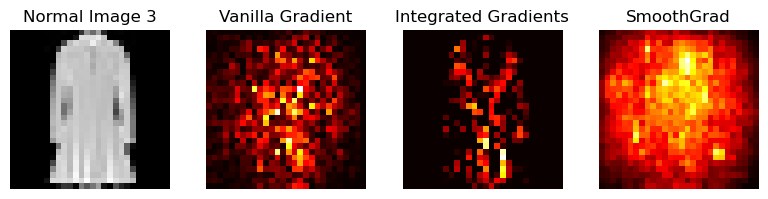

In [284]:
image_explanation_lenet(index, x_batch, y_batch, a_batch_saliency_l1, a_batch_integrad_l1, a_batch_smoothgrad_l1, 'lenet_l1_unstructured')

# Pruning Global LeNet

In [287]:
def compute_sparsity(model):
    conv1_sparsity = torch.sum(model.conv_1.weight == 0) 
    conv2_sparsity = torch.sum(model.conv_2.weight == 0)
    fc1_sparsity = torch.sum(model.fc_1.weight == 0) 
    fc2_sparsity = torch.sum(model.fc_2.weight == 0) 
    fc3_sparsity = torch.sum(model.fc_3.weight == 0) 

    num = conv1_sparsity + conv2_sparsity +fc1_sparsity + fc2_sparsity + fc3_sparsity
    denom = model.conv_1.weight.nelement() + model.conv_2.weight.nelement() + model.fc_1.weight.nelement() + model.fc_2.weight.nelement() + model.fc_3.weight.nelement()

    global_sparsity = num/denom * 100

    return global_sparsity

In [289]:
from pathlib import Path

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lenet_fmnist_global.pth"
model_save_path = model_path / model_name
model_global = LeNet().to(device)

parameters_to_prune = (
    (model_global.conv_1, 'weight'),
    (model_global.conv_2, 'weight'),
    (model_global.fc_1, 'weight'),
    (model_global.fc_2, 'weight'),
    (model_global.fc_3, 'weight')
)

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"LeNet-5 global sparsity = {compute_sparsity_lenet(model_global):.2f}%")

        
model_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
LeNet-5 global sparsity = 20.00%


<All keys matched successfully>

In [291]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [293]:
# Applying explanation methods on the model outputs
a_batch_integrad_global = IntegratedGradients(model_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_global[a_batch_integrad_global<0] = 0
a_batch_saliency_global =Saliency(model_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_global)
a_batch_smoothgrad_global = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

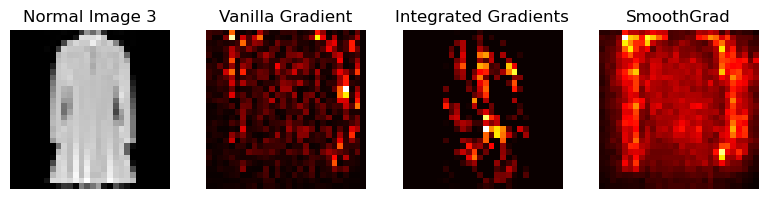

In [295]:
image_explanation_lenet(index, x_batch, y_batch, a_batch_saliency_global, a_batch_integrad_global, a_batch_smoothgrad_global, 'lenet_global')

# Pruning Layered Strutured LeNet

In [298]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "lenet_fmnist_structured.pth"
model_save_path = model_path / model_name
model_structured = LeNet().to(device)

# # Prune layer-wise in a structured manner-
prune.ln_structured(model_structured.conv_1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.conv_2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.fc_1, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.fc_2, name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.fc_3, name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"LeNet-5 global sparsity = {compute_sparsity_lenet(model_structured):.2f}%")

model_structured.load_state_dict(torch.load(model_save_path))


LeNet-5 global sparsity = 10.05%


<All keys matched successfully>

In [300]:
new_params = count_params(model_structured)
print(f"Pruned LeNet-5 model has {new_params} trainable parameters")

Pruned LeNet-5 model has 44426 trainable parameters


In [302]:
# Model to GPU and eval mode.
model_structured.to(device)
model_structured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_structured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for LeNet Pruned Layered Structure is: {(100 * test_acc):.2f}%")

Test accuracy for LeNet Pruned Layered Structure is: 85.99%


In [303]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [304]:
# Applying explanation methods on the model outputs
a_batch_integrad_structured = IntegratedGradients(model_structured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_structured[a_batch_integrad_structured<0] = 0
a_batch_saliency_structured = Saliency(model_structured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_structured)
a_batch_smoothgrad_structured = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

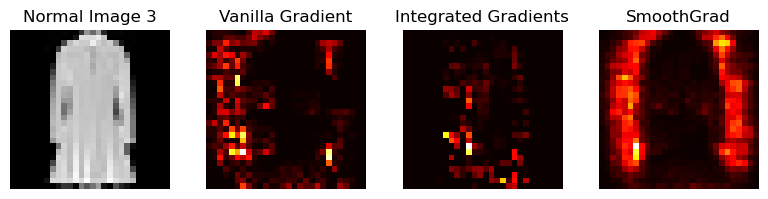

In [305]:
image_explanation_lenet(index, x_batch, y_batch, a_batch_saliency_structured, a_batch_integrad_structured, a_batch_smoothgrad_structured, 'lenet_layered_structure')

# Quantitative Metrics

In [90]:
def explainer_wrapper(**kwargs):
    """
    A wrapper function to call the appropriate explanation method.
    """
    
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")

def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    """
    Generate explanations for a model's predictions using the SmoothGrad method.

    Args:
        model: The model to explain.
        inputs : Input samples.
        targets: Target labels corresponding to the inputs.
        abs : Whether to use the absolute value of gradients.
        normalise: Whether to normalize the explanation
        stdevs: Standard deviation of the noise added to inputs
        nt_samples: Number of noisy samples to generate for SmoothGrad.

    Returns:
        numpy.ndarray: Explanation maps for the input samples.
    """
    # Standard deviation for input noise
    std = kwargs.get("std", 0.15)
    # Number of noisy samples
    n = kwargs.get("n", 10)  
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    # convert to tensor
    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 1),kwargs.get("img_size", 28),kwargs.get("img_size", 28),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    # check shape of inputs
    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size)"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 28),
                kwargs.get("img_size", 28),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        )
    # Using Vanilla Gradient as base
    saliency = Saliency(model)
    # Using Noise Tunnel to apply Smoothgrad
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 28), kwargs.get("img_size", 28))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation



In [365]:
xai_method=["SmoothGrad"]

In [367]:
%run metrics.ipynb

# ROAD VANILLA GRADIENT

In [370]:
result_normal = filter_and_compute_road(model, test_dataloader, "Saliency", device, resnet = False)

In [131]:
result_adv = filter_and_compute_road(model_adv, test_dataloader,"Saliency", device, resnet = False)

In [132]:
result_l1 = filter_and_compute_road(model_l1_unstructured, test_dataloader,"Saliency", device, resnet = False)

In [133]:
result_global = filter_and_compute_road(model_global, test_dataloader,"Saliency", device, resnet = False)

In [134]:
result_structured = filter_and_compute_road(model_structured, test_dataloader,"Saliency", device, resnet = False)

In [320]:
# result_normal = {1: np.float64(0.9844854956685247), 6: np.float64(0.9601773405033717), 11: np.float64(0.9462793275892779), 16: np.float64(0.9320755835851731), 21: np.float64(0.9185321058597737), 26: np.float64(0.907272826108309), 31: np.float64(0.8935757538544833), 36: np.float64(0.8756828245153664), 41: np.float64(0.8608572216294816), 46: np.float64(0.8369069712730111), 51: np.float64(0.81089413750982), 56: np.float64(0.7836124994981023), 61: np.float64(0.7506982060490168), 66: np.float64(0.7212911175490401), 71: np.float64(0.6715027123743628), 76: np.float64(0.6163162658225142), 81: np.float64(0.5520095779911875), 86: np.float64(0.462154225005235), 91: np.float64(0.3527233638186942), 96: np.float64(0.206259583157867)}

# result_adv = {1: np.float64(0.9784887141668596), 6: np.float64(0.9148737215952913), 11: np.float64(0.8613692667873483), 16: np.float64(0.8156581314281601), 21: np.float64(0.7684427936714078), 26: np.float64(0.7311736824541964), 31: np.float64(0.6981557336950193), 36: np.float64(0.6649713234430049), 41: np.float64(0.6343025599905177), 46: np.float64(0.6016068593697005), 51: np.float64(0.575977582092817), 56: np.float64(0.547732786699348), 61: np.float64(0.5224107892954218), 66: np.float64(0.5028750802440705), 71: np.float64(0.4685943963858188), 76: np.float64(0.43596653681329506), 81: np.float64(0.40151391080873944), 86: np.float64(0.3524782417572674), 91: np.float64(0.28162590080917177), 96: np.float64(0.18456697271332367)}

# result_l1 = {1: np.float64(0.9800281172399402), 6: np.float64(0.9523477404062433), 11: np.float64(0.9391650115085876), 16: np.float64(0.9287058182763377), 21: np.float64(0.9135735668972256), 26: np.float64(0.8987437605964155), 31: np.float64(0.8792405982258785), 36: np.float64(0.8585685003221338), 41: np.float64(0.8339734140099169), 46: np.float64(0.8050061025319618), 51: np.float64(0.7715680600769824), 56: np.float64(0.7320588191284931), 61: np.float64(0.6895584588350214), 66: np.float64(0.6448867398456325), 71: np.float64(0.5947319422723085), 76: np.float64(0.5391925577182053), 81: np.float64(0.4702104797173135), 86: np.float64(0.3818970499480194), 91: np.float64(0.28066783195399686), 96: np.float64(0.19067423136167114)}


# result_global = {1: np.float64(0.9863599631281816), 6: np.float64(0.9648606218726464), 11: np.float64(0.9484600909303748), 16: np.float64(0.929726279938663), 21: np.float64(0.9155582933401949), 26: np.float64(0.8970912369605175), 31: np.float64(0.8738226844519299), 36: np.float64(0.8469080502788339), 41: np.float64(0.8206924459324536), 46: np.float64(0.7852070655313734), 51: np.float64(0.7476214343174669), 56: np.float64(0.7022069456149361), 61: np.float64(0.6546251707145911), 66: np.float64(0.602321383478087), 71: np.float64(0.5398179606367312), 76: np.float64(0.4711102124476821), 81: np.float64(0.3890911021792515), 86: np.float64(0.3041491832434923), 91: np.float64(0.2210505379300701), 96: np.float64(0.18181256939569612)}


# result_structured = {1: np.float64(0.9693622025635528), 6: np.float64(0.8557121109918903), 11: np.float64(0.7799599109804368), 16: np.float64(0.6951855318013537), 21: np.float64(0.6033277533181827), 26: np.float64(0.5133133901038343), 31: np.float64(0.4153596027748639), 36: np.float64(0.3263351161063908), 41: np.float64(0.26374597093666546), 46: np.float64(0.21229029380969197), 51: np.float64(0.17625548532138413), 56: np.float64(0.1584847823710398), 61: np.float64(0.13658204879361163), 66: np.float64(0.12705926974080434), 71: np.float64(0.11862424254025587), 76: np.float64(0.10918910081717834), 81: np.float64(0.11228555018606204), 86: np.float64(0.10547290052294755), 91: np.float64(0.1027351184515786), 96: np.float64(0.09939090152563455)}



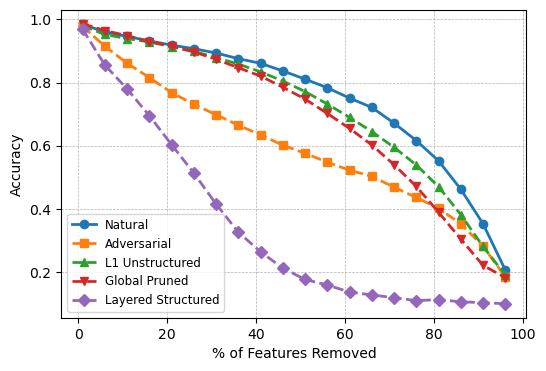

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global.values()), label='Global Pruned', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_structured.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=8.5)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LeNet_FMNIST_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# ROAD INTEGRATED GRADIENTS

In [371]:
result_normal_ig = filter_and_compute_road(model, test_dataloader,"IntegratedGradients", device, resnet = False)

In [138]:
result_adv_ig = filter_and_compute_road(model_adv, test_dataloader,"IntegratedGradients", device, resnet = False)

In [139]:
result_l1_ig = filter_and_compute_road(model_l1_unstructured, test_dataloader,"IntegratedGradients", device, resnet = False)

In [140]:
result_global_ig = filter_and_compute_road(model_global, test_dataloader,"IntegratedGradients", device, resnet = False)

In [141]:
result_structured_ig = filter_and_compute_road(model_structured, test_dataloader,"IntegratedGradients", device, resnet = False)

In [322]:
# result_normal_ig = {1: np.float64(0.9571861561741071), 6: np.float64(0.8541702713905273), 11: np.float64(0.7857191924232476), 16: np.float64(0.7449636948450788), 21: np.float64(0.7130407541425058), 26: np.float64(0.6968422614029876), 31: np.float64(0.692954440391777), 36: np.float64(0.6925580511542523), 41: np.float64(0.700268692838132), 46: np.float64(0.7002986470550611), 51: np.float64(0.7061744200406568), 56: np.float64(0.7066356843429329), 61: np.float64(0.7160170071170423), 66: np.float64(0.7063831309673265), 71: np.float64(0.670485769791013), 76: np.float64(0.5790150629777454), 81: np.float64(0.4662259772042589), 86: np.float64(0.33215212838480485), 91: np.float64(0.19005476032348892), 96: np.float64(0.12835932514833498)}

# result_adv_ig = {1: np.float64(0.9623506450492519), 6: np.float64(0.8291326841164252), 11: np.float64(0.7238828998598498), 16: np.float64(0.6381025755693459), 21: np.float64(0.5706917731808451), 26: np.float64(0.5300313225099752), 31: np.float64(0.5084017084878111), 36: np.float64(0.5003284815397157), 41: np.float64(0.5029514828707868), 46: np.float64(0.5050362855197681), 51: np.float64(0.48350846333066894), 56: np.float64(0.48727101185163824), 61: np.float64(0.5059404900589665), 66: np.float64(0.5128243798546868), 71: np.float64(0.4914990353529359), 76: np.float64(0.4368881850535025), 81: np.float64(0.35420726962336135), 86: np.float64(0.272619777194173), 91: np.float64(0.1475860023682795), 96: np.float64(0.11508804419980431)}


# result_l1_ig = {1: np.float64(0.9546692899385718), 6: np.float64(0.8518451089605616), 11: np.float64(0.7931467785306594), 16: np.float64(0.7618112778446198), 21: np.float64(0.7415434006780912), 26: np.float64(0.7340975617184298), 31: np.float64(0.7319306613770679), 36: np.float64(0.7389285270567041), 41: np.float64(0.746442890024107), 46: np.float64(0.7487499757526207), 51: np.float64(0.7378046419110653), 56: np.float64(0.7398309283574738), 61: np.float64(0.7316933615001777), 66: np.float64(0.7158083756612162), 71: np.float64(0.6714729451940243), 76: np.float64(0.5589185373242402), 81: np.float64(0.43540194090390005), 86: np.float64(0.3120457601813834), 91: np.float64(0.19969375304393933), 96: np.float64(0.13628131159379706)}


# result_global_ig = {1: np.float64(0.9671728367333982), 6: np.float64(0.8775888310699311), 11: np.float64(0.8118169123427729), 16: np.float64(0.7708809272549908), 21: np.float64(0.7412648545675212), 26: np.float64(0.7219273506734429), 31: np.float64(0.7148707470638908), 36: np.float64(0.7167458316891746), 41: np.float64(0.7222270553524084), 46: np.float64(0.6928496826570658), 51: np.float64(0.6346951848728503), 56: np.float64(0.6345001518595381), 61: np.float64(0.6218259011680554), 66: np.float64(0.6166592647379663), 71: np.float64(0.5800287848051817), 76: np.float64(0.469189387471017), 81: np.float64(0.34319521443203777), 86: np.float64(0.2208376486529162), 91: np.float64(0.15630383912573093), 96: np.float64(0.11744798440477333)}


# result_structured_ig = {1: np.float64(0.9595324599969806), 6: np.float64(0.9006782981225996), 11: np.float64(0.8890655684479372), 16: np.float64(0.8846435285826504), 21: np.float64(0.8764352963125895), 26: np.float64(0.8555089886938294), 31: np.float64(0.8462818946115533), 36: np.float64(0.8406138074247446), 41: np.float64(0.7925896276886177), 46: np.float64(0.6456855506364457), 51: np.float64(0.5264474436965559), 56: np.float64(0.46217085327715646), 61: np.float64(0.39941283970068564), 66: np.float64(0.3205841290022392), 71: np.float64(0.23673037955614182), 76: np.float64(0.19250213957446047), 81: np.float64(0.16262252511254385), 86: np.float64(0.15385556252546062), 91: np.float64(0.1372795417271405), 96: np.float64(0.1173497390800979)}


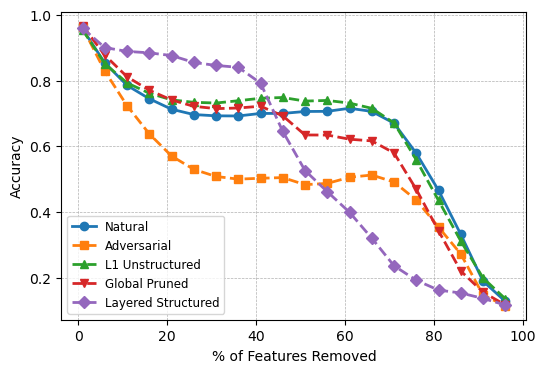

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal_ig.keys()),list(result_normal_ig.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_adv_ig.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_l1_ig.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_global_ig.values()), label='Global Pruned', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_structured_ig.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)
# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=8.5)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LeNet_FMNIST_IG_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# ROAD SMOOTHGRAD

In [372]:
result_normal_smooth = filter_and_compute_road(model, test_dataloader, "SmoothGrad", device, resnet = False)

In [56]:
result_adv_smooth = filter_and_compute_road(model_adv, test_dataloader, "SmoothGrad",device, resnet = False)

In [57]:
result_l1_smooth = filter_and_compute_road(model_l1_unstructured, test_dataloader, "SmoothGrad",device, resnet = False)

In [58]:
result_global_smooth = filter_and_compute_road(model_global, test_dataloader, "SmoothGrad",device, resnet = False)

In [59]:
result_structured_smooth = filter_and_compute_road(model_structured, test_dataloader, "SmoothGrad",device, resnet = False)

In [318]:
# result_normal_smooth = {1: np.float64(0.9871451787647073), 6: np.float64(0.9621935724760148), 11: np.float64(0.9431214917555233), 16: np.float64(0.9230388994678517), 21: np.float64(0.8998206960983144), 26: np.float64(0.8678289258048324), 31: np.float64(0.8406230445252891), 36: np.float64(0.7970718098300655), 41: np.float64(0.7630328716179432), 46: np.float64(0.7219605270139265), 51: np.float64(0.6645669014868976), 56: np.float64(0.6112108285871797), 61: np.float64(0.5458924086991507), 66: np.float64(0.481893731345829), 71: np.float64(0.40862146234118124), 76: np.float64(0.35350746997735377), 81: np.float64(0.3000937714337404), 86: np.float64(0.25273929276785634), 91: np.float64(0.20510507745156467), 96: np.float64(0.139521942354233)}

# result_adv_smooth ={1: np.float64(0.9723948214441518), 6: np.float64(0.8935365512034315), 11: np.float64(0.8286859908277606), 16: np.float64(0.7720674844523729), 21: np.float64(0.7236428866885526), 26: np.float64(0.6791685211899633), 31: np.float64(0.630228947815582), 36: np.float64(0.5874616649752413), 41: np.float64(0.543225980336581), 46: np.float64(0.5078365803825261), 51: np.float64(0.4712821320253475), 56: np.float64(0.4375909487667833), 61: np.float64(0.4017247443638569), 66: np.float64(0.3747724553864136), 71: np.float64(0.35172801091127387), 76: np.float64(0.3329185940639074), 81: np.float64(0.2996518465569803), 86: np.float64(0.24995754827128808), 91: np.float64(0.18858372091608325), 96: np.float64(0.1262011728832623)}

# result_l1_smooth ={1: np.float64(0.9848517131773437), 6: np.float64(0.9559392184574725), 11: np.float64(0.9344405750658108), 16: np.float64(0.9097741350944181), 21: np.float64(0.8811953973338826), 26: np.float64(0.8495543253258585), 31: np.float64(0.8066961651694091), 36: np.float64(0.7593821601239098), 41: np.float64(0.7185347430774723), 46: np.float64(0.6659841022371548), 51: np.float64(0.6117063459938298), 56: np.float64(0.5626256950953623), 61: np.float64(0.500902870703085), 66: np.float64(0.4274943701922975), 71: np.float64(0.3450755235545402), 76: np.float64(0.2809884577421185), 81: np.float64(0.22452342786980028), 86: np.float64(0.17547825816869725), 91: np.float64(0.14775593111190818), 96: np.float64(0.12571227369968296)}

# result_global_smooth = {1: np.float64(0.9835740243910439), 6: np.float64(0.9432478552085856), 11: np.float64(0.9048216507709839), 16: np.float64(0.8508776842445196), 21: np.float64(0.7983466989743583), 26: np.float64(0.7284174381135752), 31: np.float64(0.6572570297946801), 36: np.float64(0.5886483710038687), 41: np.float64(0.5065405889878205), 46: np.float64(0.4386278785513998), 51: np.float64(0.37846792056050405), 56: np.float64(0.3267095885095353), 61: np.float64(0.28331972216242834), 66: np.float64(0.2411731326002889), 71: np.float64(0.20690586193396793), 76: np.float64(0.17958667439776835), 81: np.float64(0.16468911327994984), 86: np.float64(0.14646367202780447), 91: np.float64(0.13853469286816983), 96: np.float64(0.12916026845817483)}

# result_structured_smooth = {1: np.float64(0.9763328931672982), 6: np.float64(0.8879881019154446), 11: np.float64(0.77297569372167), 16: np.float64(0.6355212607716629), 21: np.float64(0.48291671378793766), 26: np.float64(0.3461759087143896), 31: np.float64(0.24395189535976597), 36: np.float64(0.18378386154210508), 41: np.float64(0.1511217848481948), 46: np.float64(0.1314893008283651), 51: np.float64(0.12112637096541173), 56: np.float64(0.11300756933528418), 61: np.float64(0.11028204046056557), 66: np.float64(0.10478430657599337), 71: np.float64(0.1077761614162197), 76: np.float64(0.10667563623437151), 81: np.float64(0.10313278013894694), 86: np.float64(0.10608898764906591), 91: np.float64(0.10898969448195793), 96: np.float64(0.11395076550459106)}


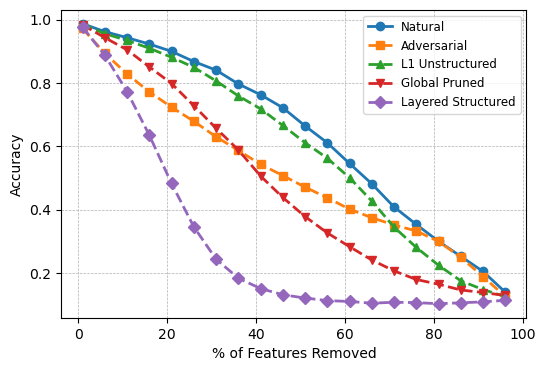

In [39]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(list(result_normal_smooth.keys()),list(result_normal_smooth.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_adv_smooth.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_l1_smooth.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_global_smooth.values()), label='Global Pruned', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_structured_smooth.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)
# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=8.5)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/LeNet_FMNIST_SMOOTH_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# INPUT STABILITY VANILLA GRADIENT

In [373]:
normal_input_saliency = filter_and_compute_input_stability(model, test_dataloader,"Saliency", device, resnet = False)
print("The relative input stability score is: ", normal_input_saliency)

The relative input stability score is:  4.873129513926875


In [161]:
adversarial_input_saliency = filter_and_compute_input_stability(model_adv, test_dataloader,"Saliency", device, resnet = False)
print("The relative input stability score is: ", adversarial_input_saliency)

The relative input stability score is:  4.225695502027566


In [162]:
l1_input_saliency =  filter_and_compute_input_stability(model_l1_unstructured, test_dataloader,"Saliency", device, resnet = False)
print("The relative input stability score is: ", l1_input_saliency)

The relative input stability score is:  4.573288190834013


In [163]:
global_input_saliency = filter_and_compute_input_stability(model_global, test_dataloader,"Saliency", device, resnet = False)
print("The relative input stability score is: ", global_input_saliency)

The relative input stability score is:  4.160707619092476


In [164]:
layered_input_saliency = filter_and_compute_input_stability(model_structured, test_dataloader,"Saliency", device, resnet = False)
print("The relative input stability score is: ", layered_input_saliency)

The relative input stability score is:  5.016785834655409


# INPUT STABILITY INTEGRATED GRADIENT

In [374]:
normal_input_ig  = filter_and_compute_input_stability(model, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative input stability score is: ", normal_input_ig)

The relative input stability score is:  4.894045487476771


In [166]:
adversarial_input_ig = filter_and_compute_input_stability(model_adv, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative input stability score is: ", adversarial_input_ig)

The relative input stability score is:  4.316235615069907


In [167]:
l1_input_ig = filter_and_compute_input_stability(model_l1_unstructured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative input stability score is: ",l1_input_ig)

The relative input stability score is:  3.758161243759267


In [168]:
global_input_ig = filter_and_compute_input_stability(model_global, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative input stability score is: ", global_input_ig)

The relative input stability score is:  0.5750025243673051


In [169]:
layered_input_ig = filter_and_compute_input_stability(model_structured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative input stability score is: ", layered_input_ig)

The relative input stability score is:  6.18274377011576


# INPUT STABILITY SMOOTHGRAD

In [375]:
normal_input_smooth  =  filter_and_compute_input_stability(model, test_dataloader, "SmoothGrad",device, resnet = False)
print("The relative input stability score is: ",normal_input_smooth)

The relative input stability score is:  -2.3638007877996876


In [183]:
adversarial_input_smooth =  filter_and_compute_input_stability(model_adv, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative input stability score is: ",adversarial_input_smooth)

The relative input stability score is:  -1.7823288032721591


In [184]:
l1_input_smooth = filter_and_compute_input_stability(model_l1_unstructured, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative input stability score is: ", l1_input_smooth)

The relative input stability score is:  -2.0172942618764056


In [185]:
global_input_smooth = filter_and_compute_input_stability(model_global, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative input stability score is: ", global_input_smooth)

The relative input stability score is:  -2.274979903117145


In [186]:
layered_input_smooth = filter_and_compute_input_stability(model_structured, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative input stability score is: ", layered_input_smooth)

The relative input stability score is:  0.7478442923747064


In [200]:
# creating a dataframe to show the data for input stability for all explanation methods
vanilla_gradient = [normal_input_saliency, adversarial_input_saliency, l1_input_saliency, global_input_saliency, layered_input_saliency]
integrated_gradients = [normal_input_ig, adversarial_input_ig, l1_input_ig, global_input_ig, layered_input_ig]
smoothgrad = [normal_input_smooth, adversarial_input_smooth, l1_input_smooth, global_input_smooth, layered_input_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,5.066674,5.821669,-2.287188
Adversarial Model,4.225696,4.316236,-1.782329
L1 Unstructured Pruned,4.573288,3.758161,-2.017294
Global Pruned,4.160708,0.575003,-2.274980
Layered Structured Pruned,5.016786,6.182744,0.747844


# OUTPUT STABILITY VANILLA GRADIENT

In [376]:
normal_output_saliency = filter_and_compute_output_stability(model, test_dataloader,"Saliency", device, resnet = False)
print("The relative output stability score is: ", normal_output_saliency)

The relative output stability score is:  9.9239255111195


In [86]:
adversarial_output_saliency = filter_and_compute_output_stability(model_adv, test_dataloader,"Saliency", device, resnet = False)
print("The relative output stability score is: ", adversarial_output_saliency)

The relative output stability score is:  10.491200766763761


In [87]:
l1_output_saliency = filter_and_compute_output_stability(model_l1_unstructured, test_dataloader,"Saliency", device, resnet = False)
print("The relative output stability score is: ", l1_output_saliency)

The relative output stability score is:  9.54433600676578


In [88]:
global_output_saliency = filter_and_compute_output_stability(model_global, test_dataloader,"Saliency", device, resnet = False)
print("The relative output stability score is: ", global_output_saliency)

The relative output stability score is:  9.571688178130827


In [89]:
layered_output_saliency = filter_and_compute_output_stability(model_structured, test_dataloader,"Saliency", device, resnet = False)
print("The relative output stability score is: ",layered_output_saliency )

The relative output stability score is:  9.854424967881346


# OUTPUT STABILITY INTEGRATED GRADIENT

In [377]:
normal_output_ig = filter_and_compute_output_stability(model, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative output stability score is: ", normal_output_ig)

The relative output stability score is:  9.360921427875619


In [91]:
adversarial_output_ig = filter_and_compute_output_stability(model_adv, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative output stability score is: ", adversarial_output_ig)

The relative output stability score is:  10.638913475367135


In [92]:
l1_output_ig =  filter_and_compute_output_stability(model_l1_unstructured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative output stability score is: ",l1_output_ig)

The relative output stability score is:  9.753132148435613


In [93]:
global_output_ig = filter_and_compute_output_stability(model_global, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative output stability score is: ",global_output_ig )

The relative output stability score is:  5.500438286338631


In [94]:
layered_output_ig = filter_and_compute_output_stability(model_structured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative output stability score is: ", layered_output_ig)

The relative output stability score is:  11.408792743159324


# OUTPUT STABILITY SMOOTHGRAD

In [378]:
normal_output_smooth =  filter_and_compute_output_stability(model, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative output stability score is: ",normal_output_smooth)

The relative output stability score is:  2.802498245689071


In [97]:
adversarial_output_smooth =  filter_and_compute_output_stability(model_adv, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative output stability score is: ",adversarial_output_smooth)

The relative output stability score is:  4.275068269353544


In [98]:
l1_output_smooth = filter_and_compute_output_stability(model_l1_unstructured, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative output stability score is: ", l1_output_smooth)

The relative output stability score is:  3.192582269842001


In [99]:
global_output_smooth = filter_and_compute_output_stability(model_global, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative output stability score is: ", global_output_smooth)

The relative output stability score is:  2.9948924785089353


In [100]:
layered_output_smooth = filter_and_compute_output_stability(model_structured, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative output stability score is: ", layered_output_smooth)

The relative output stability score is:  10.246903949706216


In [101]:
# creating a dataframe to show the data for output stability for all explanation methods
vanilla_gradient = [normal_output_saliency, adversarial_output_saliency, l1_output_saliency, global_output_saliency, layered_output_saliency]
integrated_gradients = [normal_output_ig, adversarial_output_ig, l1_output_ig, global_output_ig, layered_output_ig]
smoothgrad = [normal_output_smooth, adversarial_output_smooth, l1_output_smooth, global_output_smooth, layered_output_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,10.248388,9.709989,2.834908
Adversarial Model,10.491201,10.638913,4.275068
L1 Unstructured Pruned,9.544336,9.753132,3.192582
Global Pruned,9.571688,5.500438,2.994892
Layered Structured Pruned,9.854425,11.408793,10.246904


# SPARSITY VANILLA GRADIENT

In [379]:
normal_sparse_saliency = filter_and_compute_sparsity(model, test_dataloader,"Saliency", device, resnet = False)
print("The sparsity score is: ", normal_sparse_saliency)

The sparsity score is:  0.5353929176815686


In [124]:
adversarial_sparse_saliency = filter_and_compute_sparsity(model_adv, test_dataloader,"Saliency", device, resnet = False)
print("The sparsity score is: ", adversarial_sparse_saliency)

The sparsity score is:  (0.567786553556568, 0.005803276710414247)


In [125]:
l1_sparse_saliency =  filter_and_compute_sparsity(model_l1_unstructured, test_dataloader,"Saliency", device, resnet = False)
print("The sparsity score is: ",l1_sparse_saliency)

The sparsity score is:  (0.545625553741832, 0.004213131618629125)


In [126]:
global_sparse_saliency = filter_and_compute_sparsity(model_global, test_dataloader,"Saliency", device, resnet = False)
print("The sparsity score is: ", global_sparse_saliency)

The sparsity score is:  (0.6036586866658717, 0.007687796444217604)


In [127]:
layered_sparse_saliency = filter_and_compute_sparsity(model_structured, test_dataloader,"Saliency", device, resnet = False)
print("The sparsity score is: ",layered_sparse_saliency  )

The sparsity score is:  (0.7910504827975011, 0.009565304980180553)


# SPARSITY INTEGRATED GRADIENT

In [380]:
normal_sparse_ig =  filter_and_compute_sparsity(model, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The sparsity score is: ",normal_sparse_ig)

The sparsity score is:  0.7729951314646315


In [129]:
adversarial_sparse_ig = filter_and_compute_sparsity(model_adv, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The sparsity score is: ",adversarial_sparse_ig )

The sparsity score is:  (0.773559511057318, 0.014989847356781468)


In [130]:
l1_sparse_ig = filter_and_compute_sparsity(model_l1_unstructured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The sparsity score is: ", l1_sparse_ig)

The sparsity score is:  (0.7720026135998528, 0.01552885635228196)


In [131]:
global_sparse_ig = filter_and_compute_sparsity(model_global, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The sparsity score is: ",global_sparse_ig )

The sparsity score is:  (0.7674200542197189, 0.0146018313506834)


In [132]:
layered_sparse_ig = filter_and_compute_sparsity(model_structured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The sparsity score is: ", layered_sparse_ig)

The sparsity score is:  (0.850306168389013, 0.010784806913349557)


# SPARSITY SMOOTHGRAD

In [381]:
normal_sparse_smooth = filter_and_compute_sparsity(model, test_dataloader, "SmoothGrad",device, resnet = False)
print("The sparsity score is: ",normal_sparse_smooth )

The sparsity score is:  0.3473473900093605


In [136]:
adversarial_sparse_smooth = filter_and_compute_sparsity(model_adv, test_dataloader,"SmoothGrad", device, resnet = False)
print("The sparsity score is: ", adversarial_sparse_smooth)

The sparsity score is:  (0.4228882196351659, 0.005825839358584965)


In [137]:
l1_sparse_smooth = filter_and_compute_sparsity(model_l1_unstructured, test_dataloader,"SmoothGrad", device, resnet = False)
print("The sparsity score is: ", l1_sparse_smooth)

The sparsity score is:  (0.35473342218460663, 0.004543606507123993)


In [138]:
global_sparse_smooth = filter_and_compute_sparsity(model_global, test_dataloader,"SmoothGrad", device, resnet = False)
print("The sparsity score is: ", global_sparse_smooth)

The sparsity score is:  (0.418018706893464, 0.008366724387788765)


In [139]:
layered_sparse_smooth =  filter_and_compute_sparsity(model_structured, test_dataloader,"SmoothGrad", device, resnet = False)
print("The sparsity score is: ",layered_sparse_smooth)

The sparsity score is:  (0.6249091006791578, 0.008828304940229424)


In [140]:
# creating a dataframe to show the data for Sparsity for all explanation methods
vanilla_gradient = [normal_sparse_saliency, adversarial_sparse_saliency, l1_sparse_saliency, global_sparse_saliency, layered_sparse_saliency]
integrated_gradients = [normal_sparse_ig, adversarial_sparse_ig, l1_sparse_ig, global_sparse_ig, layered_sparse_ig]
smoothgrad = [normal_sparse_smooth, adversarial_sparse_smooth, l1_sparse_smooth, global_sparse_smooth, layered_sparse_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,"(0.5353929176789969, 0.0037229877908571333)","(0.7729951314646315, 0.014269488272607404)","(0.34745736041242725, 0.0043840386908674985)"
Adversarial Model,"(0.567786553556568, 0.005803276710414247)","(0.773559511057318, 0.014989847356781468)","(0.4228882196351659, 0.005825839358584965)"
L1 Unstructured Pruned,"(0.545625553741832, 0.004213131618629125)","(0.7720026135998528, 0.01552885635228196)","(0.35473342218460663, 0.004543606507123993)"
Global Pruned,"(0.6036586866658717, 0.007687796444217604)","(0.7674200542197189, 0.0146018313506834)","(0.418018706893464, 0.008366724387788765)"
Layered Structured Pruned,"(0.7910504827975011, 0.009565304980180553)","(0.850306168389013, 0.010784806913349557)","(0.6249091006791578, 0.008828304940229424)"
